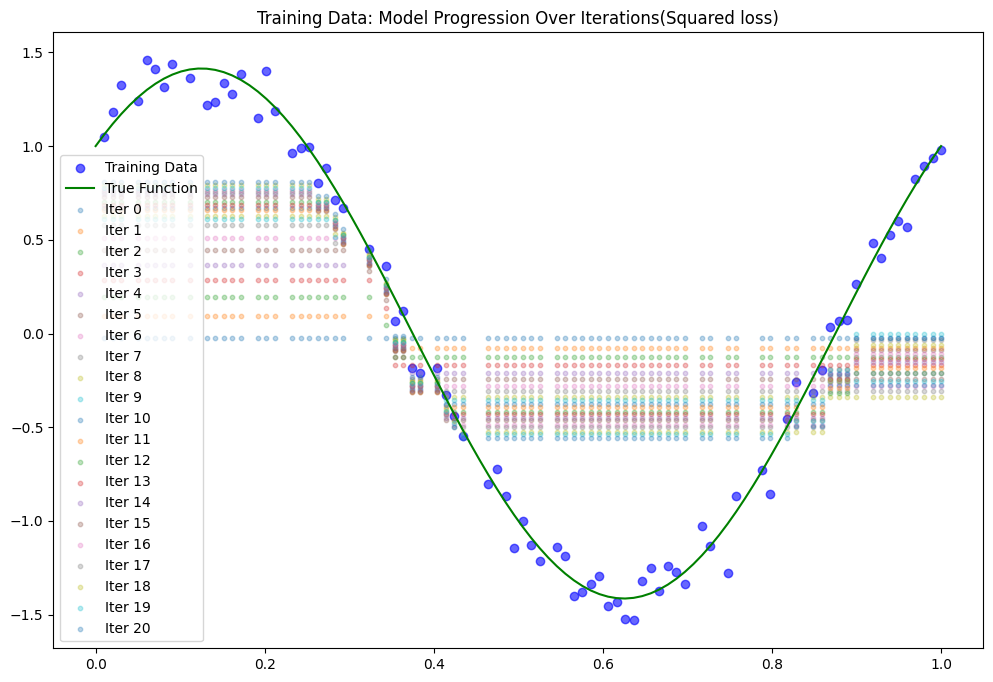

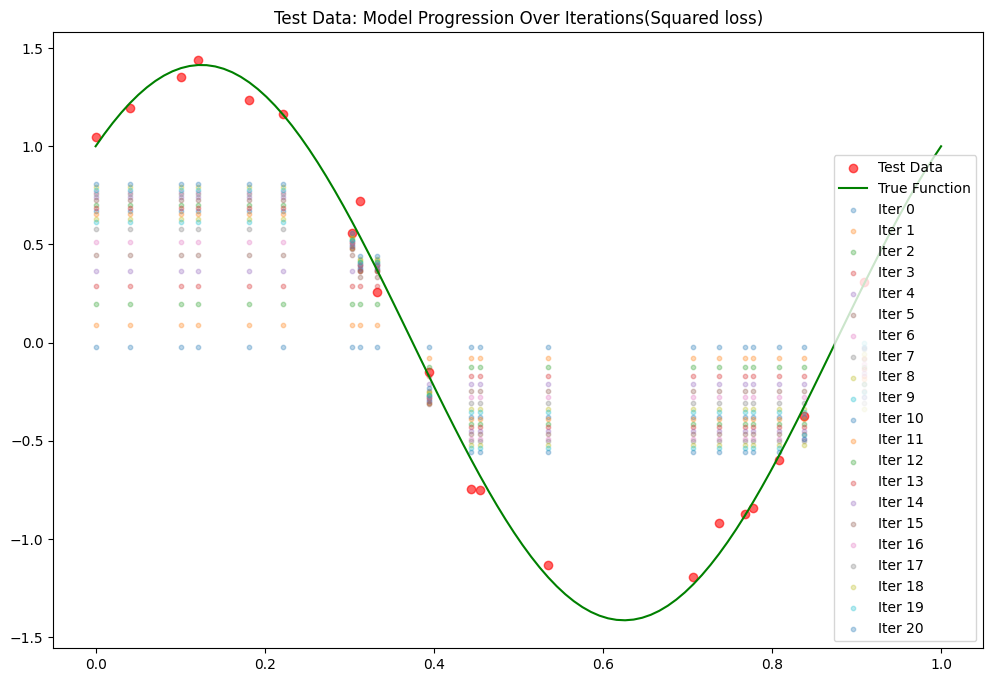

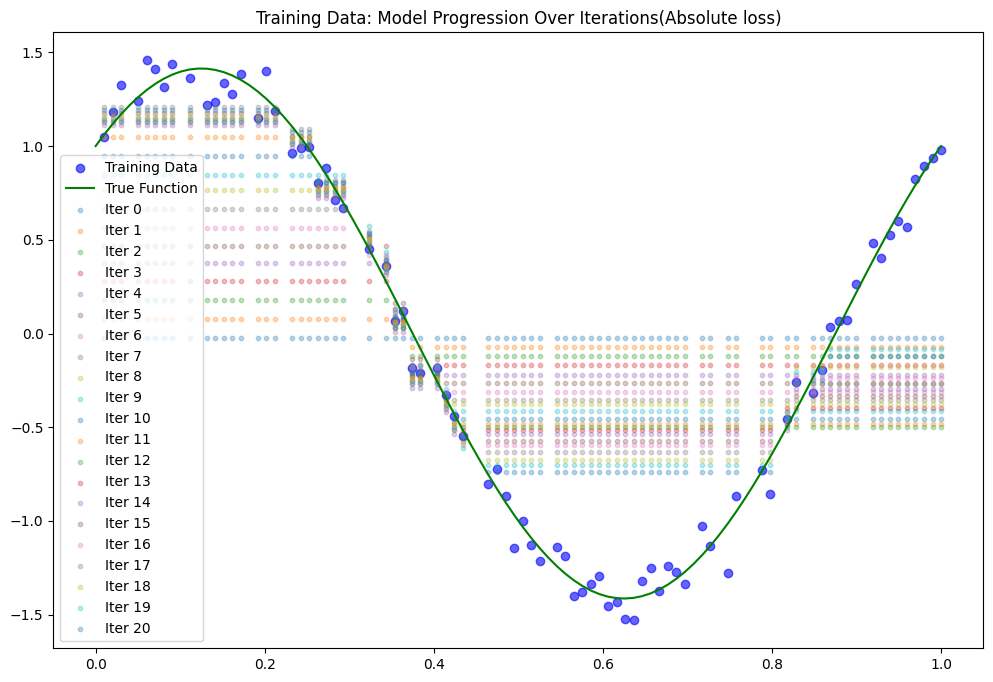

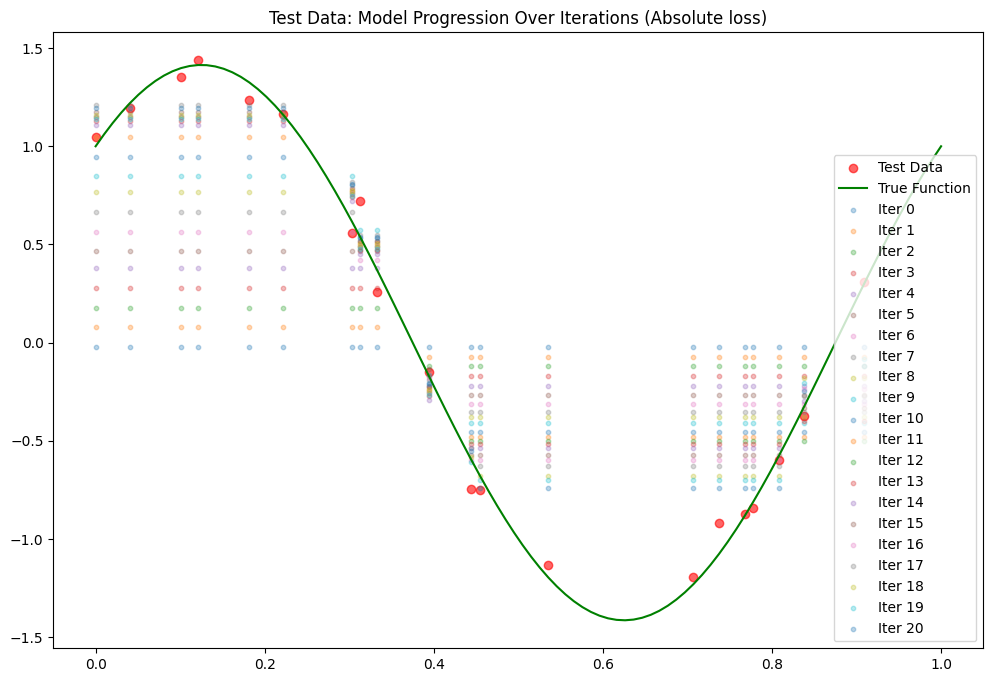

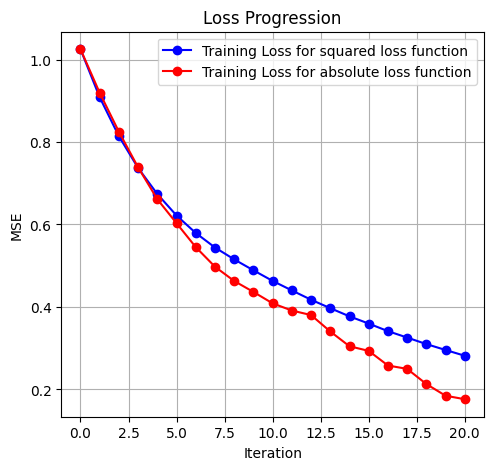

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate data
np.random.seed(42)
x = np.linspace(0, 1, 100)
noise = np.random.normal(0, np.sqrt(0.01), size=x.shape)
y = np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x) + noise
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Helper functions
def rss(values):
    if len(values) == 0:
        return 0
    mean_val = np.mean(values)
    return np.sum((values - mean_val)**2)

def get_potential_splits(x_train, indices):
    x = x_train[indices]
    x_sorted = np.sort(x)
    splits = [(x_sorted[i] + x_sorted[i+1])/2 for i in range(len(x_sorted)-1)]
    return splits

def get_best_split(x_train, y_train, indices):
    x = x_train[indices]
    y = y_train[indices]
    splits = get_potential_splits(x_train, indices)

    min_rss = float('inf')
    best_split = None

    for threshold in splits:
        left_mask = x <= threshold
        right_mask = ~left_mask

        left_indices = np.array(indices)[left_mask]
        right_indices = np.array(indices)[right_mask]

        left_rss = rss(y_train[left_indices])
        right_rss = rss(y_train[right_indices])
        total_rss = left_rss + right_rss

        if total_rss < min_rss:
            min_rss = total_rss
            best_split = {
                "threshold": threshold,
                "left_indices": left_indices,
                "right_indices": right_indices,
                "rss": total_rss
            }

    return best_split

def build_decision_stump(x_train, y_train):
    indices = list(range(len(x_train)))
    best_split = get_best_split(x_train, y_train, indices)

    left_value = np.mean(y_train[best_split["left_indices"]])
    right_value = np.mean(y_train[best_split["right_indices"]])

    return {
        "threshold": best_split["threshold"],
        "left_value": left_value,
        "right_value": right_value
    }

def predict_with_stump(stump, x_val):
    if x_val <= stump["threshold"]:
        return stump["left_value"]
    else:
        return stump["right_value"]



# Gradient boosting implementation
learning_rate = 0.1
n_estimators = 20

# Initialize predictions for TRAIN and TEST data
F_train = np.full_like(y_train, y_train.mean())
F_train2= np.full_like(y_train, y_train.mean())
F_test = np.full_like(x_test, y_train.mean())  # Same initial value (F0)
F_test2 = np.full_like(x_test, y_train.mean())  # Same initial value (F0)

# Store predictions over iterations
train_predictions = [F_train.copy()]
train_predictions2 = [F_train2.copy()]
test_predictions = [F_test.copy()]
test_predictions2 = [F_test2.copy()]

train_loss = [np.mean((y_train - F_train)**2)]
train_loss2 = [np.mean((y_train - F_train2)**2)]

for _ in range(n_estimators):
    # 1. Compute residuals (negative gradient) for TRAINING DATA
    residuals = y_train - F_train
    residuals2 = np.sign(y_train - F_train2)

    # 2. Fit a stump to the residuals (ONLY ON TRAINING DATA)
    stump = build_decision_stump(x_train, residuals)
    stump2 = build_decision_stump(x_train, residuals2)

    # 3. Update model for TRAINING DATA
    h_train = np.array([predict_with_stump(stump, x) for x in x_train])
    F_train += learning_rate * h_train
    h_train2 = np.array([predict_with_stump(stump2, x) for x in x_train])
    F_train2 += learning_rate * h_train2
    train_loss.append(np.mean((y_train - F_train)**2))
    train_loss2.append(np.mean((y_train - F_train2)**2))

    # 4. Update model for TEST DATA (using the same stump)
    h_test = np.array([predict_with_stump(stump, x) for x in x_test])
    F_test += learning_rate * h_test
    h_test2 = np.array([predict_with_stump(stump2, x) for x in x_test])
    F_test2 += learning_rate * h_test2

    # Store predictions for visualization
    train_predictions.append(F_train.copy())
    test_predictions.append(F_test.copy())
    train_predictions2.append(F_train2.copy())
    test_predictions2.append(F_test2.copy())

# Plot training progression
plt.figure(figsize=(12, 8))
plt.scatter(x_train, y_train, label='Training Data', color='blue', alpha=0.6)
plt.plot(x, np.sin(2*np.pi*x) + np.cos(2*np.pi*x), label='True Function', color='green')
for i, pred in enumerate(train_predictions):
    plt.scatter(x_train, pred, label=f'Iter {i}', alpha=0.3, s=10)
plt.title('Training Data: Model Progression Over Iterations(Squared loss)')
plt.legend()
plt.show()

# Plot test progression (IN A SEPARATE GRAPH)
plt.figure(figsize=(12, 8))
plt.scatter(x_test, y_test, label='Test Data', color='red', alpha=0.6)
plt.plot(x, np.sin(2*np.pi*x) + np.cos(2*np.pi*x), label='True Function', color='green')
for i, pred in enumerate(test_predictions):
    plt.scatter(x_test, pred, label=f'Iter {i}', alpha=0.3, s=10)
plt.title('Test Data: Model Progression Over Iterations(Squared loss)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(x_train, y_train, label='Training Data', color='blue', alpha=0.6)
plt.plot(x, np.sin(2*np.pi*x) + np.cos(2*np.pi*x), label='True Function', color='green')
for i, pred in enumerate(train_predictions2):
    plt.scatter(x_train, pred, label=f'Iter {i}', alpha=0.3, s=10)
plt.title('Training Data: Model Progression Over Iterations(Absolute loss)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(x_test, y_test, label='Test Data', color='red', alpha=0.6)
plt.plot(x, np.sin(2*np.pi*x) + np.cos(2*np.pi*x), label='True Function', color='green')
for i, pred in enumerate(test_predictions2):
    plt.scatter(x_test, pred, label=f'Iter {i}', alpha=0.3, s=10)
plt.title('Test Data: Model Progression Over Iterations (Absolute loss)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'b-o', label='Training Loss for squared loss function')
plt.plot(train_loss2, 'r-o', label='Training Loss for absolute loss function')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Loss Progression')
plt.legend()
plt.grid(True)
